# Set up

In [1]:
from wsi import filter
from wsi import slide
from wsi import util

import numpy as np

FILE = 'data/U.svs'

In [2]:
np_img = slide.slide_to_scaled_np_image(FILE, 64)

RGB                  | Time: 0:00:00.000304  Type: uint8   Shape: (408, 466, 3)


In [3]:
grayscale = filter.filter_rgb_to_grayscale(np_img)
complement = filter.filter_complement(grayscale)
util.display_img(complement)

Gray                 | Time: 0:00:00.004835  Type: uint8   Shape: (408, 466)
Complement           | Time: 0:00:00.000170  Type: uint8   Shape: (408, 466)


# Testing filters

## Simple threshold

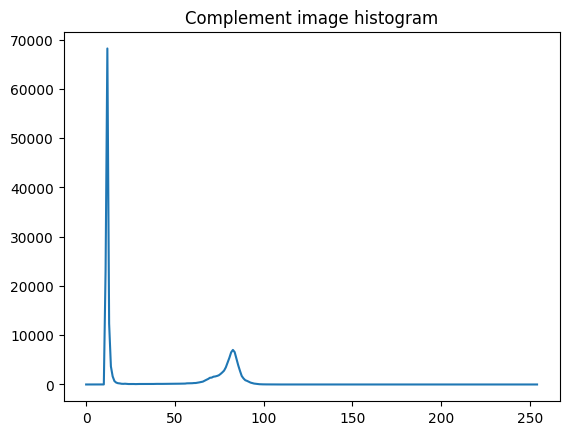

In [5]:
util.show_histogram(complement, "Complement image histogram", grayscale=True)

In [6]:
thresh = filter.filter_threshold(complement, threshold=50)
util.display_img(thresh)

Threshold            | Time: 0:00:00.000130  Type: bool    Shape: (408, 466)


In [7]:
util.display_img(util.mask_rgb(np_img, thresh))

Mask RGB             | Time: 0:00:00.002092  Type: uint8   Shape: (408, 466, 3)


## Otsu threshold

In [8]:
otsu = filter.filter_otsu_threshold(complement)
util.display_img(otsu)
util.display_img(util.mask_rgb(np_img, otsu))

Otsu Threshold       | Time: 0:00:00.097967  Type: uint8   Shape: (408, 466)
Mask RGB             | Time: 0:00:00.001225  Type: uint8   Shape: (408, 466, 3)


## Binary closing
Fill in small holes in binary mask by dialation, then erosion. 

In [9]:
bin_closing = filter.filter_binary_closing(otsu, disk_size=10)
util.display_img(bin_closing)
util.display_img(util.mask_rgb(np_img, bin_closing))

Binary Closing       | Time: 0:00:00.082277  Type: uint8   Shape: (408, 466)
Mask RGB             | Time: 0:00:00.001120  Type: uint8   Shape: (408, 466, 3)


## Binary opening
Expand small holes in binary mask by erosion, then dialation.

In [10]:
bin_opening = filter.filter_binary_opening(otsu, disk_size=10)
util.display_img(bin_opening)
util.display_img(util.mask_rgb(np_img, bin_opening))

Binary Opening       | Time: 0:00:00.081843  Type: uint8   Shape: (408, 466)
Mask RGB             | Time: 0:00:00.001094  Type: uint8   Shape: (408, 466, 3)


## Remove small objects

In [11]:
rm_obj = filter.filter_remove_small_objects(otsu)
util.display_img(rm_obj)
util.display_img(util.mask_rgb(np_img, rm_obj))

Remove Small Objs    | Time: 0:00:00.004858  Type: uint8   Shape: (408, 466)
Mask RGB             | Time: 0:00:00.001066  Type: uint8   Shape: (408, 466, 3)


## Remove small holes

In [12]:
rm_hole = filter.filter_remove_small_holes(otsu)
util.display_img(rm_hole)
util.display_img(util.mask_rgb(np_img, rm_hole))

/Users/oliviashen/Desktop/fall24/rubinet/DeskBrainSec/wsi/filter.py:268: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  rem_sm = sk_morphology.remove_small_holes(np_img, area_threshold=min_size)


Remove Small Holes   | Time: 0:00:00.006491  Type: uint8   Shape: (408, 466)
Mask RGB             | Time: 0:00:00.001045  Type: uint8   Shape: (408, 466, 3)


# Plaque segmentation with HED color space
- H = hematosylin, dyes nucleic acids purple-blue,
- E = eosin, dyes tissues pink
- D = diaminobenzoate, dyes amyloid plaques brown

Extract a sample tile generated from tiling script:

In [4]:
from PIL import Image

sample = Image.open('tiles/U/0/6/7.jpg')
sample = util.pil_to_np_rgb(sample)
util.display_img(sample)

RGB                  | Time: 0:00:00.063647  Type: uint8   Shape: (2048, 2048, 3)


Filter for diaminobenzoate channel (indicates amyloid plaques)

In [5]:
hed_patch = filter.filter_rgb_to_hed(sample)
dab = filter.filter_hed_to_dab(hed_patch)
util.display_img(dab)

RGB to HED           | Time: 0:00:00.282377  Type: uint8   Shape: (2048, 2048, 3)
HED to DAB           | Time: 0:00:00.036570  Type: uint8   Shape: (2048, 2048)


Apply Gaussian blur to de-noise DAB channel.

In [6]:
dab = filter.filter_gaussian(dab, sigma=2)
util.display_img(dab)

Gaussian             | Time: 0:00:00.158635  Type: uint8   Shape: (2048, 2048)


Pick a pixel value threshold based on histogram. 100 seems to filter out most non-plaque areas.

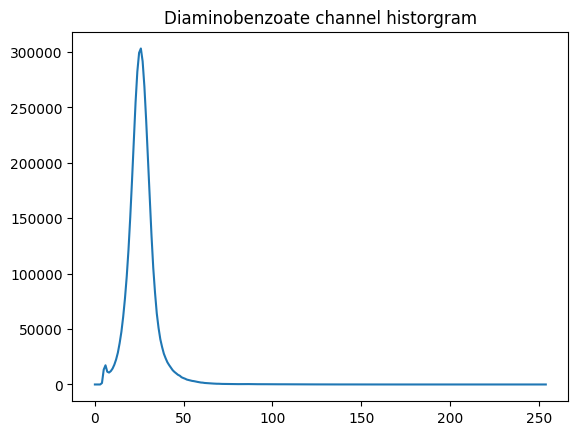

In [7]:
util.show_histogram(dab, "Diaminobenzoate channel historgram", grayscale=True)

Apply threshold.

In [8]:
dab_mask = filter.filter_threshold(dab, 100)
util.display_img(dab_mask)
util.display_img(util.mask_rgb(sample, dab_mask))

Threshold            | Time: 0:00:00.000692  Type: bool    Shape: (2048, 2048)
Mask RGB             | Time: 0:00:00.014790  Type: uint8   Shape: (2048, 2048, 3)
